# Model based method

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
airdata=pd.read_excel('Airlines+Data.xlsx')
airdata

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


array([[<AxesSubplot:title={'center':'Passengers'}>]], dtype=object)

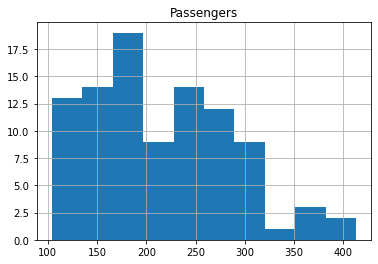

In [3]:
airdata.hist()

<AxesSubplot:>

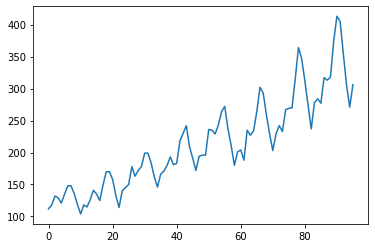

In [4]:
airdata.Passengers.plot()

In [5]:
airdata['Date']=pd.to_datetime(airdata.Month,format='%b-%y')

In [6]:
airdata['month']=airdata.Date.dt.strftime('%b')
airdata['year']=airdata.Date.dt.strftime('%Y')

<AxesSubplot:xlabel='month', ylabel='year'>

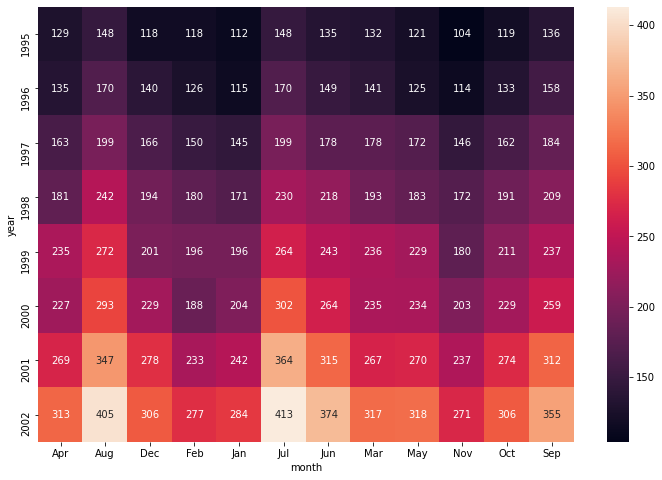

In [7]:
plt.figure(figsize=(12,8))
hm_y_mth=pd.pivot_table(data=airdata,values='Passengers',index='year',columns='month',aggfunc='mean',fill_value=0)
sns.heatmap(data=hm_y_mth,annot=True,fmt='g')

<AxesSubplot:xlabel='year', ylabel='Passengers'>

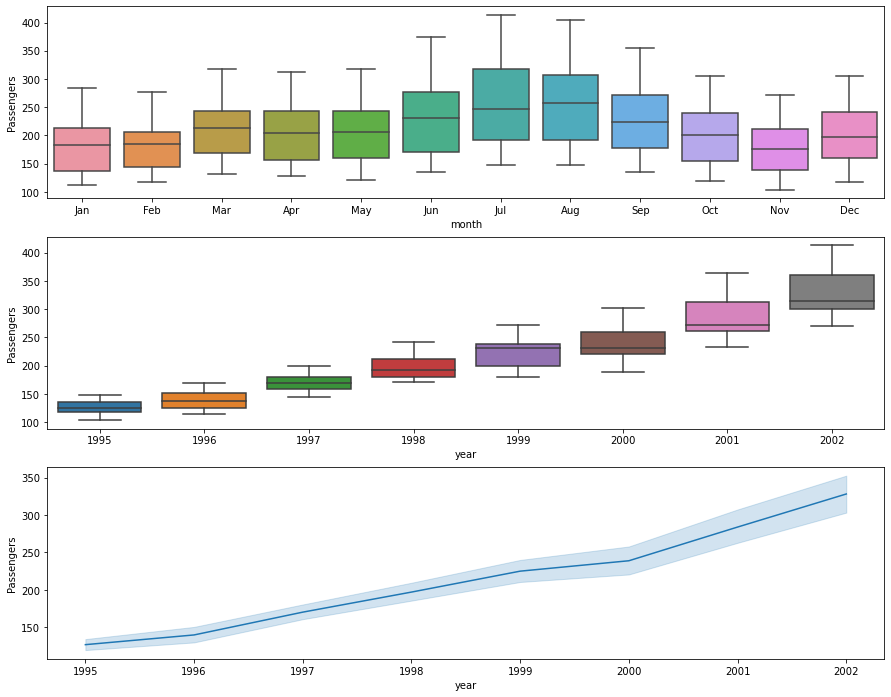

In [8]:
plt.figure(figsize=(15,12))
plt.subplot(311)
sns.boxplot(x='month',y='Passengers',data=airdata)
plt.subplot(312)
sns.boxplot(x='year',y='Passengers',data=airdata)
plt.subplot(313)
sns.lineplot(x='year',y='Passengers',data=airdata)

### Time - Series Decomposition Plot

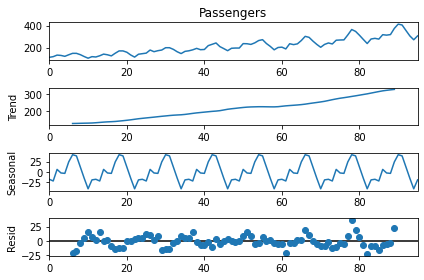

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
dec_ts_add=seasonal_decompose(airdata.Passengers,period=12)
dec_ts_add.plot()
plt.show()

In [10]:
airdata['t']=np.arange(1,97)
airdata['t2']=airdata['t']*airdata['t']
airdata['log_Passengers']=np.log(airdata['Passengers'])
airdata

,Month,Passengers,Date,month,year,t,t2,log_Passengers
0,1995-01-01,112,1995-01-01,Jan,1995,1,1,4.718499
1,1995-02-01,118,1995-02-01,Feb,1995,2,4,4.770685
2,1995-03-01,132,1995-03-01,Mar,1995,3,9,4.882802
3,1995-04-01,129,1995-04-01,Apr,1995,4,16,4.859812
4,1995-05-01,121,1995-05-01,May,1995,5,25,4.795791
...,...,...,...,...,...,...,...,...
91,2002-08-01,405,2002-08-01,Aug,2002,92,8464,6.003887
92,2002-09-01,355,2002-09-01,Sep,2002,93,8649,5.872118
93,2002-10-01,306,2002-10-01,Oct,2002,94,8836,5.723585
94,2002-11-01,271,2002-11-01,Nov,2002,95,9025,5.602119


In [11]:
airdata.nunique()

Month             96
Passengers        80
Date              96
month             12
year               8
t                 96
t2                96
log_Passengers    80
dtype: int64

In [12]:
# Splitting data
train=airdata.head(84)
test=airdata.tail(12)

### Creating different Models

In [13]:
# Linear Model
import statsmodels.formula.api as smf

lin_model=smf.ols('Passengers~t',data=train).fit()
pred_lin=lin_model.predict(test['t'])
rmse_lin=sqrt(mean_squared_error(test['Passengers'],pred_lin))
rmse_lin

53.19923653480269

In [14]:
# Exponential
exp=smf.ols('log_Passengers~t',data=train).fit()
pred_exp=exp.predict(test['t'])
rmse_exp=sqrt(mean_squared_error(test['Passengers'],np.exp(pred_exp)))
rmse_exp

46.057361103156246

In [15]:
# Quadratic
quad=smf.ols('Passengers~t+t2',data=train).fit()
pred_quad=quad.predict(test[['t','t2']])
rmse_quad=sqrt(mean_squared_error(test['Passengers'],pred_quad))
rmse_quad

48.05188897933101

In [16]:
# Compare Results
data={'Model':pd.Series(['rmse_exp','rmse_lin','rmse_quad']),'RMSE_Values':pd.Series([rmse_exp,rmse_lin,rmse_quad])}
table=pd.DataFrame(data)
table.sort_values('RMSE_Values')

,Model,RMSE_Values
0,rmse_exp,46.057361
2,rmse_quad,48.051889
1,rmse_lin,53.199237


# Data Driven Model

In [17]:
data=pd.read_excel('Airlines+Data.xlsx')

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,ExponentialSmoothing,Holt

In [19]:
train=data.head(84)
test=data.tail(12)

### Moving Average

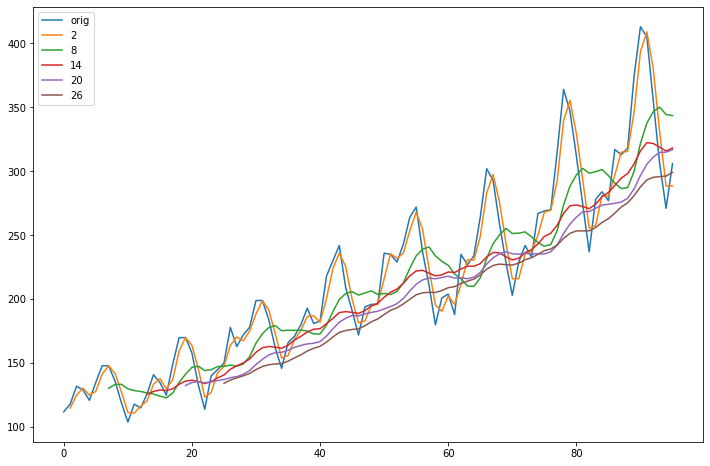

In [20]:
plt.figure(figsize=(12,8))
airdata.Passengers.plot(label='orig')
for i in range(2,30,6):
    airdata.Passengers.rolling(i).mean().plot(label=str(i))

plt.legend(loc='best')

### ACF & PACF Plots

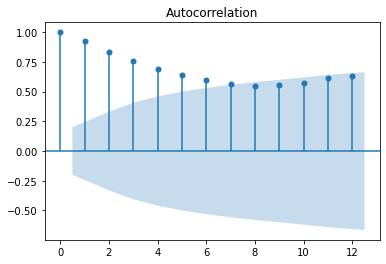

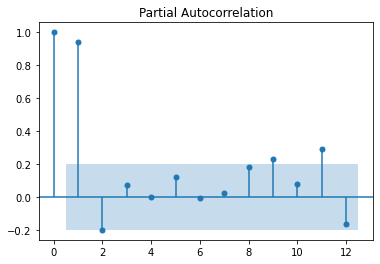

In [21]:
import statsmodels.graphics.tsaplots as tsaplots
tsaplots.plot_acf(airdata.Passengers,lags=12)
tsaplots.plot_pacf(airdata.Passengers,lags=12)
plt.show()

In [22]:
# MAPE
def MAPE(pred,org):
    temp=np.abs((pred-org)/org)*100
    return np.mean(temp)


## Simple Exponential Method

In [23]:
train['Passengers']=train['Passengers'].astype('float')
ses_model=SimpleExpSmoothing(train['Passengers']).fit(smoothing_level=0.2)
pred_ses=ses_model.predict(start=test.index[0],end=test.index[-1])
pred_ses
MAPE_ses=MAPE(pred_ses,test.Passengers)
MAPE_ses

<ipython-input-23-975ad6580e77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Passengers']=train['Passengers'].astype('float')
C:\Users\Aswathy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


13.41127474051367

In [24]:
rmse_ses=sqrt(mean_squared_error(test['Passengers'],pred_ses))
rmse_ses

64.84476396990442

### Holt Method

In [25]:
hw_model=Holt(train.Passengers).fit(smoothing_level=0.8,smoothing_slope=0.2)
pred_hw=hw_model.predict(start=test.index[0],end=test.index[-1])
MAPE_hw=MAPE(pred_hw,test.Passengers)
MAPE_hw

C:\Users\Aswathy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
<ipython-input-25-74c5eaafa46a>:1: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  hw_model=Holt(train.Passengers).fit(smoothing_level=0.8,smoothing_slope=0.2)


23.530719652100924

In [26]:
rmse_hw=sqrt(mean_squared_error(test.Passengers,pred_hw))
rmse_hw

95.76674452675374

### Holt Winter Exponential Smoothing with additive Seasonality and additive Trend

In [27]:
hwe_add_sea_trend_model=ExponentialSmoothing(train['Passengers'],seasonal='add',trend='add',seasonal_periods=12).fit()
pred_hwe_add_sea_trend=hwe_add_sea_trend_model.predict(start=test.index[0],end=test.index[-1])
MAPE_hwe_add_sea=MAPE(pred_hwe_add_sea_trend,test.Passengers)
MAPE_hwe_add_sea

C:\Users\Aswathy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


5.499258483636923

In [28]:
rmse_hwe_add_sea=sqrt(mean_squared_error(test.Passengers,pred_hwe_add_sea_trend))
rmse_hwe_add_sea

28.80730725721676

### Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [29]:
hwe_mul_sea_trend_model=ExponentialSmoothing(train.Passengers,seasonal='mul',trend='add',seasonal_periods=12).fit()
pred_hwe_mul_sea_trend=hwe_mul_sea_trend_model.predict(start=test.index[0],end=test.index[-1])
MAPE_hwe_mul_sea=MAPE(pred_hwe_mul_sea_trend,test.Passengers)
MAPE_hwe_mul_sea

C:\Users\Aswathy\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


2.8205793420354914

In [30]:
rmse_hwe_mul_sea=sqrt(mean_squared_error(test.Passengers,pred_hwe_mul_sea_trend))
rmse_hwe_mul_sea

12.919179883239396

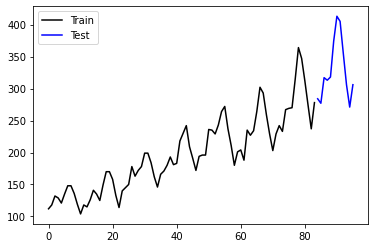

In [31]:
plt.plot(train.index,train["Passengers"],label="Train",color="black") 
plt.plot(test.index,test["Passengers"],label="Test",color="blue")
plt.legend()

In [32]:
Table={"Model":pd.Series(["MAPE_hw","MAPE_ses","MAPE_hwe_add_sea","MAPE_hwe_mul_sea"]),"MAPE_VALUES":pd.Series([MAPE_hw,MAPE_ses,MAPE_hwe_add_sea,MAPE_hwe_mul_sea])}
Table=pd.DataFrame(Table) 
Table.sort_values('MAPE_VALUES')

,Model,MAPE_VALUES
3,MAPE_hwe_mul_sea,2.820579
2,MAPE_hwe_add_sea,5.499258
1,MAPE_ses,13.411275
0,MAPE_hw,23.530720


In [33]:
table_rmse_data={'Model':pd.Series(['rmse_ses','rmse_hw','rmse_hwe_add_sea','rmse_hwe_mul_sea']),"RMSE_Values": pd.Series([rmse_ses,rmse_hw,rmse_hwe_add_sea,rmse_hwe_mul_sea])}
table_rmse_data=pd.DataFrame(table_rmse_data)
table_rmse_data.sort_values('RMSE_Values')

,Model,RMSE_Values
3,rmse_hwe_mul_sea,12.919180
2,rmse_hwe_add_sea,28.807307
0,rmse_ses,64.844764
1,rmse_hw,95.766745


# ARIMA Model

In [34]:
data1=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True,squeeze=True)

<AxesSubplot:ylabel='Density'>

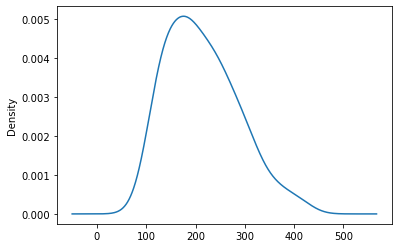

In [35]:
data1.plot(kind='kde')

In [36]:
# Seperate Validation dataset
split_point=len(data1)-10
dataset,validation=data1[:split_point],data1[split_point:]
print('Dataset %d, Validation %d'% (len(dataset),len(validation)))
dataset.to_csv('dataset.csv',header=False)
validation.to_csv('validation.csv',header=False)

Dataset 86, Validation 10


## Persistance / Base Model

In [37]:
train = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = train.values
X=X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

In [38]:
# walk-forward validation
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
# observation
    obs = test[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=230.000, Expected=242.000
>Predicted=242.000, Expected=209.000
>Predicted=209.000, Expected=191.000
>Predicted=191.000, Expected=172.000
>Predicted=172.000, Expected=194.000
>Predicted=194.000, Expected=196.000
>Predicted=196.000, Expected=196.000
>Predicted=196.000, Expected=236.000
>Predicted=236.000, Expected=235.000
>Predicted=235.000, Expected=229.000
>Predicted=229.000, Expected=243.000
>Predicted=243.000, Expected=264.000
>Predicted=264.000, Expected=272.000
>Predicted=272.000, Expected=237.000
>Predicted=237.000, Expected=211.000
>Predicted=211.000, Expected=180.000
>Predicted=180.000, Expected=201.000
>Predicted=201.000, Expected=204.000
>Predicted=204.000, Expected=188.000
>Predicted=188.000, Expected=235.000
>Predicted=235.000, Expected=227.000
>Predicted=227.000, Expected=234.000
>Predicted=234.000, Expected=264.000
>Predicted=264.000, Expected=302.000
>Predicted=302.000, Expected=293.000
>Predicted=293.000, Expected=259.000
>Predicted=259.000, Expected=229.000
>

## ARIMA Hyperparameters

In [39]:
import warnings
from statsmodels.tsa.arima_model import ARIMA

In [40]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X,arima_order):
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    
    history=[x for x in train]
    prediction=list()
    for t in range(len(test)):
        model=ARIMA(history,order=arima_order)
        model_fit=model.fit(disp=0)
        yhat=model_fit.forecast()[0]
        prediction.append(yhat)
        history.append(test[t])
        
    # Calculate Error
    rmse=sqrt(mean_squared_error(test,prediction))
    return rmse

## Grid Search for p,d,q values

In [41]:
# evaluate combinations of p,d,q for different ARIMA Models
def evaluate_models(dataset,p_values,d_values,q_values):
    dataset=dataset.astype('float32')
    best_score,best_cfg=float('inf'),None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                try:
                    rmse=evaluate_arima_model(train,order)
                    if rmse<best_score:
                        best_score,best_cfg=rmse,order
                    print("ARIMA %s, RMSE= %.3f"%(order,rmse))
                except:
                    continue
    print('Best ARIMA %s, RMSE= %.3f'% (best_cfg,best_score))
    

In [42]:
import warnings
warnings.filterwarnings('ignore')

train=pd.read_csv('dataset.csv',header=0,index_col=0,parse_dates=True,squeeze=True)
# Evaluate Parameters
p_values=range(0,3)
d_values=range(0,3)
q_values=range(0,3)

evaluate_models(train.values,p_values,d_values,q_values)

ARIMA (0, 0, 0), RMSE= 77.671
ARIMA (0, 0, 1), RMSE= 44.264
ARIMA (0, 1, 0), RMSE= 25.904
ARIMA (0, 1, 1), RMSE= 25.361
ARIMA (0, 1, 2), RMSE= 27.770
ARIMA (0, 2, 0), RMSE= 32.477
ARIMA (0, 2, 1), RMSE= 26.665
ARIMA (0, 2, 2), RMSE= 25.962
ARIMA (1, 0, 0), RMSE= 26.047
ARIMA (1, 0, 1), RMSE= 25.289
ARIMA (1, 1, 0), RMSE= 25.683
ARIMA (1, 1, 1), RMSE= 25.155
ARIMA (1, 1, 2), RMSE= 23.051
ARIMA (1, 2, 0), RMSE= 31.607
ARIMA (2, 0, 0), RMSE= 25.623
ARIMA (2, 0, 1), RMSE= 25.704
ARIMA (2, 1, 0), RMSE= 25.471
ARIMA (2, 1, 1), RMSE= 22.554
ARIMA (2, 2, 0), RMSE= 30.423
Best ARIMA (2, 1, 1), RMSE= 22.554


## Build model based on optimized values

In [43]:
model=ARIMA(X,order=(2,1,0))
model_fit=model.fit()
forecast=model_fit.forecast(10)[0]
forecast

array([275.82212268, 278.8935408 , 281.74576394, 283.6225487 ,
       285.30732666, 287.15650987, 289.08771092, 291.00339676,
       292.89748395, 294.78963199])

### Since we got the least value of rmse for "Holts winter exponential smoothing with multiplicative seasonality and additive trend", we use the same Data Driven method for Final forecast

## Final Model by combining train and test - Data Driven Method

In [45]:
airdata['Passengers']=airdata['Passengers'].astype('double')
hwe_mul_sea_trend_model=ExponentialSmoothing(airdata['Passengers'],seasonal='mul',trend='add',seasonal_periods=12).fit()

In [46]:
hwe_mul_sea_trend_model.forecast(10)

96     312.899483
97     308.172137
98     355.532626
99     345.771258
100    345.697121
101    392.471492
102    436.502350
103    429.860359
104    380.174318
105    332.318757
dtype: float64

### For comparison we will take the forecast results of ARIMA method also

## Final Model by combining train and test - ARIMA Method

In [51]:
data_final=pd.read_excel('Airlines+Data.xlsx',header=0,index_col=0,parse_dates=True)
X=airdata.Passengers.values
X=X.astype('float32')

In [52]:
model_arima=ARIMA(X,order=(2,1,1)).fit()

In [53]:
forecast=model_arima.forecast(10)[0]
forecast

array([331.5517918 , 343.01398449, 344.12863433, 340.96174896,
       338.11937862, 337.60285256, 339.36753555, 342.43818168,
       345.81583613, 348.90854057])

### Since the results converge to the original dataset for 'Holts winter exponential smoothing with multiplicative seasonality and additive trend', we will consider this as the final forecast value.